In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "10g").appName("Parquet Reader").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/22 11:19:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/22 11:19:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Initialize the airline variable globally
airline = None

def read_parquet_and_print_top(parquet_path):
    global airline
    # Read Parquet files into a DataFrame
    airline = spark.read.parquet(parquet_path)

# Initialize Spark session and read Parquet file
parquet_path = "./airline.parquet"
read_parquet_and_print_top(parquet_path)

In [4]:
# get cols 
airline.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID: 

In [ ]:
flights_month = {}

months = airline.select('Month').distinct().collect()
months = [row.Month for row in months]
# assign total and delayed for each month
for month in months:
    total = airline.filter(airline.Month == month).count()
    delayed = airline.filter(airline.Month == month).filter(airline.ArrDelay > 0).count()
    flights_month[month] = {'total': total, 'delayed': delayed}
print(flights_month)

In [ ]:
airline.columns

In [ ]:
# records where delay is more than 15
delayed_flights = airline.filter((airline.ArrDelay > 15) & (airline.Distance > 2000)).count()
delayed_flights

In [5]:
airline.head(5)

24/03/21 16:50:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(Year=2019, Quarter=2, Month=4, DayofMonth=30, DayOfWeek=2, FlightDate=datetime.date(2019, 4, 30), Reporting_Airline='AA', DOT_ID_Reporting_Airline=19805, IATA_CODE_Reporting_Airline='AA', Tail_Number='N733UW', Flight_Number_Reporting_Airline=2119, OriginAirportID=10721, OriginAirportSeqID=1072102, OriginCityMarketID=30721, Origin='BOS', OriginCityName='Boston, MA', OriginState='MA', OriginStateFips=25, OriginStateName='Massachusetts', OriginWac=13, DestAirportID=11278, DestAirportSeqID=1127805, DestCityMarketID=30852, Dest='DCA', DestCityName='Washington, DC', DestState='VA', DestStateFips=51, DestStateName='Virginia', DestWac=38, CRSDepTime=1600, DepTime=1556, DepDelay=-4.0, DepDelayMinutes=0.0, DepDel15=0.0, DepartureDelayGroups=-1, DepTimeBlk='1600-1659', TaxiOut=15.0, WheelsOff='1611', WheelsOn='1723', TaxiIn=3.0, CRSArrTime=1745, ArrTime=1726, ArrDelay=-19.0, ArrDelayMinutes=0.0, ArrDel15=0.0, ArrivalDelayGroups=-2, ArrTimeBlk='1700-1759', Cancelled=0.0, CancellationCode=None

In [ ]:
def get_top_airports(airline, years):
    top_airports = []
    result = []
    for year in years:
        # Filter flights by the specified year and on-time departures
        on_time_flights = airline.filter(
            (airline['Year'] == year) & (airline['DepDelay'] <= 0))

        # Group flights by originating airport and count occurrences also get the OriginStateName and OriginCityName
        airport_counts = on_time_flights.groupBy( 'Origin', 'OriginStateName', 'OriginCityName').count() 
        top_airports_year = airport_counts.orderBy(
            airport_counts['count'].desc()).limit(3)

        # get the OriginStateName and OriginCityName
        top_airports = []
        for i, airport in enumerate(top_airports_year.collect(), start=1):
            location = airport['OriginCityName'] + ', ' + airport['OriginStateName']    
            top_airports.append(
                {"airport": airport['Origin'], "count": airport['count'] ,"location":location, "year": year})
        result += top_airports
    return result

years = [1987, 1997, 2007, 2017]
result = get_top_airports(airline,years)
result

In [15]:
def get_worst_performing_airlines(airline):
    # Filter flights in the 20th century (years 1900-1999)
    century_flights = airline.filter(
        (airline['Year'] >= 1900) & (airline['Year'] <= 1999))


    # calculate average delay
    average_delay = century_flights.groupBy('DOT_ID_Reporting_Airline').avg('ArrDelay')
    average_delay = average_delay.withColumnRenamed('avg(ArrDelay)', 'avg_delay')

    # Filter flights with an arrival delay greater than average delay
    worst_performing_airlines = century_flights.join(average_delay, on='DOT_ID_Reporting_Airline')
    worst_performing_airlines = worst_performing_airlines.filter(worst_performing_airlines['ArrDelay'] > worst_performing_airlines['avg_delay'])
    worst_performing_airlines = worst_performing_airlines.groupBy('DOT_ID_Reporting_Airline').count().orderBy('count', ascending=False).limit(3)
    

    worst_performing_airlines_list = worst_performing_airlines.collect()

    # print("The top three worst performing airlines in the 20th century are:")
    data = []
    
    temp = SparkSession.builder.appName("Temp").getOrCreate()
    dot_csv = temp.read.csv("./SupplementaryCSVs/L_AIRLINE_ID.csv", header=True)

    for i, airline in enumerate(worst_performing_airlines_list, start=1):
        airline_name = dot_csv.filter(dot_csv['Code'] == airline['DOT_ID_Reporting_Airline']).collect()[0]
        airline_name = airline_name['Description'].split(':')[0].strip()
        # print(airline_name)
        # print(airline)
        total_flights_in_20th_century = century_flights.filter(century_flights['DOT_ID_Reporting_Airline'] == airline['DOT_ID_Reporting_Airline']).count()
        cancel_flights = century_flights.filter(century_flights['Cancelled'] == 1).count()
        # print(
        #     f"{i}. {airline['Reporting_Airline']}, Total Delays: {airline['count']}")
        data.append(
            {"airline": airline_name, "total_delays": airline['count'], "total_flights": total_flights_in_20th_century, "cancelled_flights": cancel_flights})
    return data

get_worst_performing_airlines(airline)


[{'airline': 'Delta Air Lines Inc.',
  'total_delays': 3442010,
  'total_flights': 10635384,
  'cancelled_flights': 1036421},
 {'airline': 'US Airways Inc.',
  'total_delays': 3143834,
  'total_flights': 9425130,
  'cancelled_flights': 1036421},
 {'airline': 'American Airlines Inc.',
  'total_delays': 2717380,
  'total_flights': 8666261,
  'cancelled_flights': 1036421}]

In [6]:
# print unique values of Reporting_Airline
airline.select('Reporting_Airline').distinct().show()

+-----------------+
|Reporting_Airline|
+-----------------+
|               UA|
|               NK|
|               AA|
|               EV|
|               B6|
|               DL|
|               OO|
|               F9|
|               YV|
|               MQ|
|               OH|
|               HA|
|               G4|
|               YX|
|               AS|
|               VX|
|               WN|
|               9E|
|               US|
|               FL|
+-----------------+
only showing top 20 rows



     Year OriginState  avg(DepDelay)
0    2018          NY      11.878241
1    2020          CA       3.998915
2    2016          NY      12.046742
3    2019          NY      13.520421
4    2018          CA       8.649348
..    ...         ...            ...
97   1987          TX       7.926875
98   1990          CA       5.753424
99   1991          TX       6.457995
100  1991          CA       6.313865
101  1992          NY       6.409061

[102 rows x 3 columns]


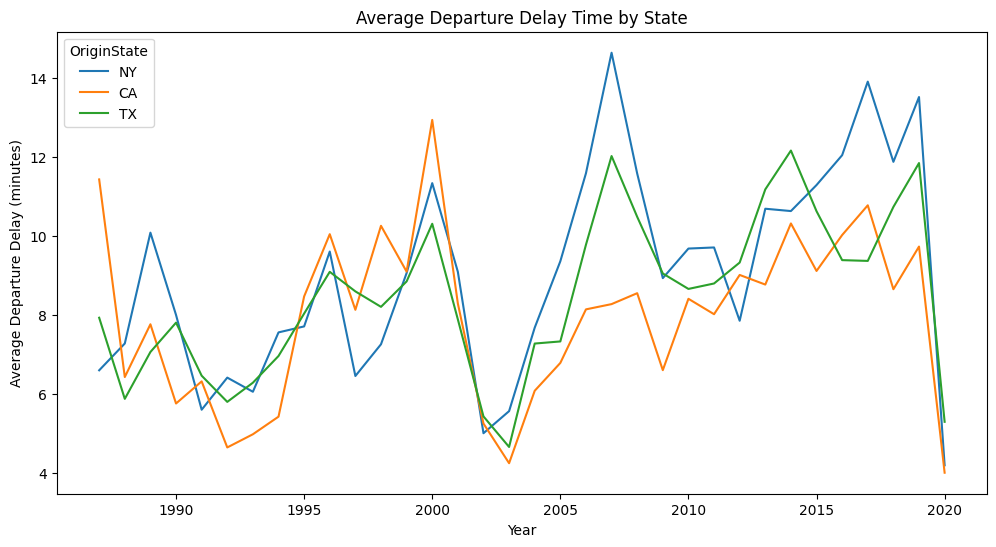

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
def compare_airport_performance(airline, states):
    # Filter flights by the specified states
    filtered_flights = airline.filter(airline['OriginState'].isin(states))

    # get data of each year
    state_performance = filtered_flights.groupBy('Year', 'OriginState').agg({'DepDelay': 'mean'}).toPandas()

    # Plot performance of states using seaborn or matplotlib
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='avg(DepDelay)', data=state_performance, hue='OriginState')
    plt.title('Average Departure Delay Time by State')
    plt.xlabel('Year')
    plt.ylabel('Average Departure Delay (minutes)')
    plt.show()
compare_airport_performance(airline, ['NY', 'CA', 'TX'])